In [2]:
from IPython.display import Image

## 6.1 파이프라인을 사용한 효율적인 워크플로

### 6.1.1 위스콘신 유방암 데이터셋

In [3]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
df.shape

(569, 32)

In [5]:
df[1].value_counts()

B    357
M    212
Name: 1, dtype: int64

In [6]:
# class label(1번 열)을 'M'과 'B'에서 정수로 변환
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [7]:
# 매핑 확인
le.transform(['M', 'B'])

array([1, 0])

In [8]:
# split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.20,
                     stratify=y,
                     random_state=1)

### 6.1.2 파이프라인으로 변환기와 추정기 연결
- StandardScaler, PCA, LogisticRegression을 한 번에 연결

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(random_state=1))

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print('테스트 정확도: %.3f' % pipe_lr.score(X_test, y_test))

테스트 정확도: 0.956


In [11]:
import matplotlib.pyplot as plt
from sklearn import set_config

set_config(display='diagram')
pipe_lr

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

In [10]:
Image(url='https://git.io/JtsTr', width=500) 

> make_pipeline 함수는 여러 개의 사이킷런 변환기(입력에 대해 fit 메서드와 transform 메서드를 지원하는 객체)와 그 뒤에 fit 메서드와 predict 메서드를 구현한 사이킷런 추정기를 연결할 수 있다.<br>

> 파이프라인의 중간 단계 횟수는 제한이 없으나, 마지막 요소는 '추정기'가 되어야 한다.

## 6.2 k-겹 교차 검증을 사용한 모델 성능 평가
- 모델이 너무 간단하면 과소적합(높은 편향)이 문제가 되고, 너무 복잡하면 훈련 데이터에 과대적합(높은 분산)될 수 있다.
- holdout cross-validation과 k-fold cross-validation은 '모델의 일반화 성능, 즉 처음 본 데이터에 모델이 얼마나 잘 동작하는지 신뢰할 만한 추정을 하도록 도와준다.'

### 6.2.1 홀드아웃 방법

In [11]:
Image(url='https://git.io/JtsTo', width=500)

> 데이터를 훈련과 테스트로 나누고, 훈련 데이터셋을 이용해서 모델을 설계한 다음에 테스트 데이터셋을 일반화 성능 평가용으로 사용한다. 근데 보통 여기서 끝나지 않고, 테스트 모델을 가지고 모델을 추가 학습 시킨다. 그러다보면 결국 테스트 데이터도 훈련 데이터가 되는 것이고, 모델은 전체 데이터셋에 대해 과대적합되는 것이다.<br>

> **홀드아웃 방법은 데이터를 훈련 데이터셋, 검증 데이터셋, 테스트 데이터셋 세 부분으로 나누는 것이다.**
<br>

- 훈련 데이터셋은 모델 훈련, 검증 데이터셋은 모델 선택, 테스트 데이터셋은 일반화 성능 평가
    - 모델 하이퍼 파라미터의 변경이나 튜닝은 검증 데이터셋을 기반으로 평가해서 조정한다.

- 위 방법의 한 가지 단점은.. 검증 데이터셋이 어떤 샘플로 이루어져 있느냐에 따라 성능 추정이 민감할 수 있다는 것이다.
- 그래서 등장하는 게 **k-fold cross-validation**이다.<br>

> 훈련 데이터셋을 $k$개의 fold로 랜덤하게 나눈다 => $k-1$개의 폴드로 모델을 훈련하고, 나머지 하나의 폴드로 성능을 평가한다. => 이 과정을 $k$번 반복하여 $k$개의 모델과 성능 추정을 얻는다. => 모델의 평균 성능을 계산한다. => 위 과정을 반복하면서 모델을 튜닝하고 최적의 하이퍼파라미터 값을 찾는다 => 만족스런 하이퍼파라미터 값을 찾고 나면 전체 훈련 데이터셋을 사용하여 모델을 다시 훈련한다 => 그 다음 독립적인 테스트 데이터셋을 사용하여 최종 성능 추정을 한다. <br>

- 중복을 허용하지 않는 리샘플링으로 fold를 나누기 때문에, 모든 샘플 포인트가 '검증'에 사용되는 장점이 있다 => 홀드아웃 방법보다 모델 성능의 추정에 분산이 낮다.
    - Class imbalance가 있을 때는 StratifiedKFold를 사용한다.

In [12]:
Image(url='https://git.io/JtsT6', width=500) 

> Ron Kahavi는 **"여러 종류의 실제 데이터셋에서 수행한 실험을 통해 k=10일 때의 교차 검증이 가장 뛰어난 편향-분산 트레이드오프를 가진다고"** 말했다.<br>

- 아주 작은 데이터셋을 다룰 때는 *LOOCV(Leave-One-Out Cross-Validation)*이라는 기법도 사용된다. 이건 폴드 개수가 훈련 샘플 개수와 같은 거다($k=n$). 하나의 훈련 샘플이 각 반복에서 테스트로 사용된다.

In [13]:
# stratified k-fold
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold): # k번째 교차검증, (훈련인덱스, 검증인덱스)
    pipe_lr.fit(X_train[train], y_train[train]) # X_train[훈련인덱스], y_train[훈련인덱스]  ==> 훈련폴드에서 model fitting 하는 것
    score = pipe_lr.score(X_train[test], y_train[test]) #X_train[검증인덱스], y_train[검증인덱스]  ==> 검증폴드에서 model assessing 하는 것
    scores.append(score)
    print('폴드: %2d, 클래스 분포: %s, 정확도: %.3f' %
         (k+1, np.bincount(y_train[train]), score))

print('\nCV 정확도: %.3f +/- %.3f' % (np.mean(scores),
                                  np.std(scores)))

폴드:  1, 클래스 분포: [256 153], 정확도: 0.935
폴드:  2, 클래스 분포: [256 153], 정확도: 0.935
폴드:  3, 클래스 분포: [256 153], 정확도: 0.957
폴드:  4, 클래스 분포: [256 153], 정확도: 0.957
폴드:  5, 클래스 분포: [256 153], 정확도: 0.935
폴드:  6, 클래스 분포: [257 153], 정확도: 0.956
폴드:  7, 클래스 분포: [257 153], 정확도: 0.978
폴드:  8, 클래스 분포: [257 153], 정확도: 0.933
폴드:  9, 클래스 분포: [257 153], 정확도: 0.956
폴드: 10, 클래스 분포: [257 153], 정확도: 0.956

CV 정확도: 0.950 +/- 0.014


In [14]:
# sklearn의 corss_val_score 사용하는 간단한 모델 평가법
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                        y=y_train,
                        cv=10,
                        n_jobs=1)
print('CV 정확도 점수: %s' % scores)
print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores),
                                np.std(scores)))

CV 정확도 점수: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.950 +/- 0.014


- cross_val_score가 검증에 사용하는 기본 측정 지표는 회귀일 때는 $R^2$, 분류일 때는 정확도다.

## 6.3 학습 곡선과 검증 곡선을 사용한 알고리즘 디버깅

### 6.3.1 학습 곡선으로 편향과 분산 문제 분석

In [15]:
Image(url='https://git.io/JtsTi', width=600)

- 왼쪽 위는 훈련 정확도와 교차검증 정확도 모두 낮다. (높은 편향)
    - 훈련 데이터에 과소적합 되어 있다.
    - 일반적인 해결법은 '모델의 파라미터 개수를 늘리는 것' => 추가적인 특성을 수집하거나 생성; SVM이나 LogisticRegression에서 규제 강도를 줄인다.
- 오른쪽 위는 훈련 정확도와 교차검증 정확도 사이에 큰 차이가 있다. (높은 분산)
    - 훈련 데이터에 과대적합 되어있다.
    - 더 많은 훈련 데이터를 모으거나, 모델 복잡도를 낮추거나, 규제를 증가시킨다.<br><br>
    
> **실전에서는 데이터를 모으는 게 비싸거나 불가능할 때도 많다. "모델의 훈련 정확도와 검증 정확도를 훈련 데이터셋의 크기 함수로 그래프를 그려 보면 모델에 높은 분산의 문제가 있는지, 높은 편향의 문제가 있는지 쉽게 볼 수 있다. 더 많은 데이터를 모으는 것이 문제를 해결할 수 있을지 판단이 가능해진다.**

In [1]:
# 학습 곡선으로 모델 평가
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                       LogisticRegression(penalty='l2',
                                          random_state=1,
                                         max_iter=10000))

train_sizes, train_scores, test_scores =\
    learning_curve(estimator=pipe_lr,
                  X=X_train,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1.0, 10),
                  cv=10,
                  n_jobs=1)
    # 훈련 데이터셋의 사이즈를 0.1배율에서 1배율까지 바꿔가면서,
        # 각 사이즈마다 10겹 교차검증을 수행한다.
        # 그리고 10겹 교차검증을 하면서 검증데이터셋에 대한 정확도뿐 아니라, 훈련데이터셋에 대한 정확도도 scoring한다.
        
        # 예를 들어.. train_size=0.1이면 총 455개 데이터샘플 중 45개를 전체세트로 생각하는 거다.
        # 40개로 훈련하고, 5개로 검증하는 걸 10번 반복한다.
            # 모델의 훈련데이터에 대한 정확도와 검증데이터에 대한 정확도를 모두 반환한다.
            
            # 위에는 train_size 비율도 10개로 나눈 다음, 각각의 세트에 대해
            # 10겹 교차검증을 수행했다.
            # 그러니까 scroing 테이블은 10x10이 된다.
            # 테이블의 1열은 train_size를 45로 놓고 10겹 교차검증 했을 때의 정확도!

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std ,
                alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Validation accuracy')

plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()

plt.show()

NameError: name 'make_pipeline' is not defined

- 위에서 보듯이, 모델 훈련에 250개 이상의 샘플을 사용할 때 훈련과 검증 데이터셋 모두에서 잘 작동한다.
    - 250개보다 줄어들면 훈련 정확도가 증가하면서 검증 정확도와의 차이가 커진다 => 과대적합이 증가한다는 뜻이다.

### 6.3.2 검증 곡선으로 과대적합과 과소적합 조사
- 검증 곡선은 학습 곡선과 관련이 있지만, **샘플 크기의 함수로 훈련 정확도와 테스트 정확도를 그리는 대신 모델 파라미터 값의 함수로 그린다.**
    - e.g. 로지스틱 회귀의 규제 매개변수 C에 대한 값으로 그린다

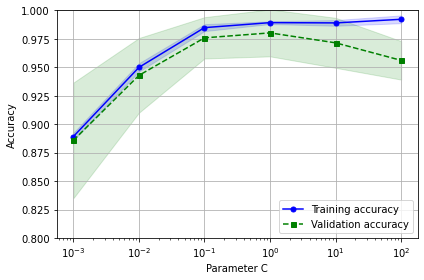

In [17]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = \
    validation_curve(estimator=pipe_lr,
                    X=X_train,
                    y=y_train,
                    param_name='logisticregression__C',
                    param_range=param_range,
                    cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean,
        color='blue', marker='o',
        markersize=5, label='Training accuracy')

plt.fill_between(param_range,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='blue')

plt.plot(param_range, test_mean,
        color='green', linestyle='--',
        marker='s', markersize=5,
        label='Validation accuracy')

plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()

plt.show()

- 규제 강도를 높이면(C 값을 줄이면) 모델이 데이터에 조금 과소적합된다.
- 규제 강도가 낮아지는 큰 C값에서는 모델이 데이터에 조금 과대적합된다.
- 이 경우 적절한 C값은 0.01과 0.1 사이다.

## 6.4 그리드 서치를 사용한 머신 러닝 모델 세부 튜닝

- 머신 러닝의 두 종류의 파라미터
    - 훈련 데이터에서 학습되는 파라미터: 예를 들어 로지스틱 회귀의 가중치
    - 별도로 최적화되는 학습 알고리즘의 파라미터: 모델의 튜닝 파라미터, aka 하이퍼파라미터; 예를 들어 로지스틱 회귀의 규제 매개변수나 결정 트리의 깊이 매개변수

### 6.4.1 그리드 서치를 사용한 하이퍼파라미터 튜닝
- 앞에서는 validation curve를 사용해 C값을 튜닝했는데,
    - 그리드 서치는 **"여러 하이퍼파라미터 값에 대한 최적의 조합"**을 찾는다.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                        SVC(random_state=1))

param_range = np.logspace(-4, 3, 8)

param_grid = [{'svc__C': param_range,
              'svc__kernel': ['linear']},
             {'svc__C': param_range,
             'svc__gamma': param_range,
             'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 refit=True,
                 cv=10,
                 n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [19]:
clf = gs.best_estimator_
    # refit=True로 지정했기 때문에 이후에 다시 clf.fit(X_train, y_train)할 필요가 없다.

In [20]:
print('테스트 정확도: %.3f' % clf.score(X_test, y_test))

테스트 정확도: 0.974


> 매개변수 탐색 범위가 넓거나 규제 매개변수 C와 같이 연속적인 값을 탐색해야 하는 경우에 RandomizedSearchCV가 더 효율적입니다. 이 클래스는 n_iter 매개변수로 탐색 횟수를 조정할 수 있어 컴퓨팅 자원에 맞게 탐색을 실행할 수 있습니다. 

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

distribution = loguniform(0.0001, 1000.0)

param_dist = [{'svc__C': distribution,
              'svc__kernel': ['linear']},
             {'svc__C': distribution,
             'svc__gamma': distribution,
             'svc__kernel': ['rbf']}]

rs = RandomizedSearchCV(estimator=pipe_svc,
                       param_distributions=param_dist,
                       n_iter=30,
                       cv=10,
                       random_state=1,
                       n_jobs=1)
rs = rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9824637681159419
{'svc__C': 210.6644070836221, 'svc__gamma': 0.0006861724481510375, 'svc__kernel': 'rbf'}


### 6.4.2 중첩 교차 검증을 사용한 알고리즘 선택
- GridSearch와 k-fold cv는 "머신 러닝 모델의 성능을 세부 튜닝"하기에 좋다.
- **"여러 종류의 머신 러닝 알고리즘을 비교하려면"** 중첩 교차 검증(nested cv) 방법이 권장된다.
    - 바깥족 k-fold cv 루프가 데이터를 훈련 폴드와 테스트 폴드로 나누고; 안쪽 루프는 훈련 폴드를 '안쪽 훈련폴드와 안쪽 검증폴드'로 나눠서 k-fold cv를 수행하며 모델을 세부튜닝한다.

In [22]:
Image(url='https://git.io/JtsTP', width=500) 

In [23]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=2)

scores = cross_val_score(gs, X_train, y_train,
                        scoring='accuracy', cv=5)

# 순서대로 하면..
    # cross_val_score가 전체 데이터셋을 5-fold로 나눈다.
    # 훈련 폴드에서 사용할 모델이 'gs'다.
    # gs는 어떤 모델이냐면..
        # 훈련 폴드를 2-fold로 나눈 다음에, pipe_svc를 param_grid로
        # 최적의 조합, 즉 가장 높은 정확도를 지닌 param 조합으로 튜닝된
        # 모델이다.
        
    # 여기서 각각의 gs가 어떤 param으로 튜닝됐는지 알려면 어떻게 해야 되지?

print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores),
                                np.std(scores)))

CV 정확도: 0.974 +/- 0.015


In [24]:
from sklearn.tree import DecisionTreeClassifier

gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth': [1,2,3,4,5,6,7,None]}],
                 scoring='accuracy',
                 cv=2)

scores = cross_val_score(gs, X_train, y_train,
                        scoring='accuracy', cv=5)

print('CV 정확도: %.3f +/- %.3f' % (np.mean(scores),
                                np.std(scores)))

CV 정확도: 0.934 +/- 0.016


## 6.5 여러 가지 성능 평가 지표

### 6.5.1 오차 행렬

In [25]:
Image(url='https://git.io/JtsT1', width=300) 

In [26]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


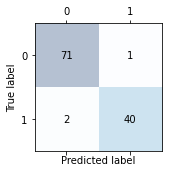

In [27]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
        
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()

plt.show()

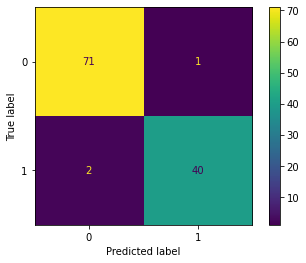

In [28]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe_svc, X_test, y_test)

plt.show()

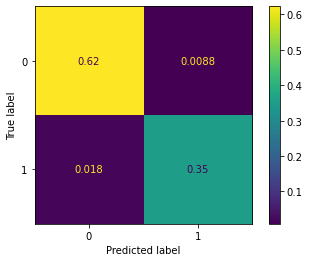

In [29]:
plot_confusion_matrix(pipe_svc, X_test, y_test,
                     normalize='all')

plt.show()

### 6.5.2 분류 모델의 정밀도와 재현율 최적화

- 예측 오차(ERR): 전체 데이터샘플 중 "잘못 분류한 비율", 틀린 비율
- 정확도(ACC): 전체 데이터샘플 중 "올바르게 분류한 비율", 맞춘 비율 = 1 - ERR<br><br>

- 정밀도(PRE) = $\dfrac{TP}{TP+FP}$
    - 내가 양성이라고 분류한 것 중 양성인 비율

- 클래스 비율이 다른 경우 유용한 지표
    - True Positive Rate(TPR) = $\dfrac{TP}{P} = \dfrac{TP}{FN+TP}$
        - 양성을 양성으로 올바르게 분류한 비율 = TPR = 재현율(recall) = 민감도(sensitivity)
    - False Positive Rate(FPR) = $\dfrac{FP}{N} = \dfrac{FP}{FP+TN}$
        - 음성을 양성으로 잘못 분류한 비율 = FPR = 특이도(specificity)

> - 악성 종양 감지 문제(class imbalance)에서 재현율을 최적화하면 '악성 종양을 감지하지 못할 확률을 최소화'하는 데 도움이 된다.<br>
> - 하지만 건강한 환자임에도 악성 종양으로 예측하는 비용이 발성한다.<br>
> - 반대로 정밀도를 최적화하면 환자가 악성 종양을 가졌는지 정확히 예측하게 되지만, 악성 종양 환자를 자주 놓치는 결과를 초래한다.

- PRE와 REC의 최적화로 인한 장단점의 균형을 맞추기 위한 scoring이 F1-score다.
    - $F1 = 2 \cdot \dfrac{Precision \times Recall}{Precision + Recall}$

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('정밀도: %.3f' % precision_score(y_test, y_pred))
print('재현율: %.3f' % recall_score(y_test, y_pred))
print('F1: %.3f' % f1_score(y_test, y_pred))

정밀도: 0.976
재현율: 0.952
F1: 0.964


- 사이킷런에서 양성 클래스는 레이블이 1인 클래스다.
- 양성 레이블을 바꾸고 싶다면 make_scorer 함수를 사용해서 자신만의 함수를 만들 수 있다. 그리고 나면 GridSearchCV의 scoring 매개변수에 전달할 수도 있다.

In [31]:
# f1_score를 GridSearchCV의 scoring parameter로 설정하기!
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### 6.5.3 ROC 곡선 그리기
- ROC 그래프는 분류기의 임계값을 바꿔가며 계산된 FPR(특이도)과 TPR(재현율)을 기반으로 분류 모델을 선택하게 도와주는 도구다.
- ROC 그래프의 대각선은 '랜덤 추측'이고, 대각선 아래 위치한 분류 모델은 랜덤 추측보다도 나쁜 모델이다.
- 완벽한 분류기의 그래프는 TPR이 1이고 FPR이 0인 왼쪽 위 구석이다.
- ROC 곡선의 아래 면적인 AUC(Area Under the Curve)를 계산해서 분류 모델의 성능을 종합할 수 있다.

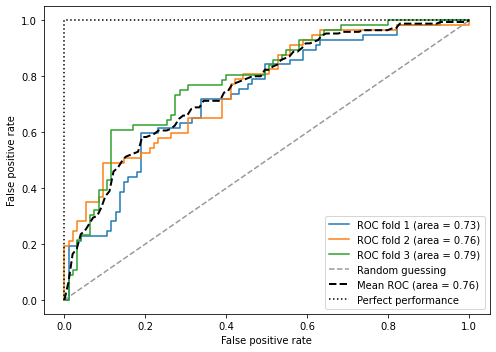

In [32]:
# ROC 곡선
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version

if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp
    

pipe_lr = make_pipeline(StandardScaler(),
                       PCA(n_components=2),
                       LogisticRegression(penalty='l2',
                                         random_state=1,
                                         C=100.0))
X_train2 = X_train[:, [4, 14]]

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                        y_train[train]).predict_proba(X_train2[test])
    fpr, tpr, thresholds = roc_curve(y_train[test],
                                    probas[:, 1],
                                    pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
            label='ROC fold %d (area = %0.2f)' % (i+1, roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--',
        color=(0.6, 0.6, 0.6), label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
        label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0,0,1], [0,1,1], linestyle=':',
        color='black', label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('False positive rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

- plot_roc_curve()와 plot_precision_recall_curve()를 사용하면 ROC 곡선과 정밀도-재현율 곡선을 쉽게 그릴 수 있다.

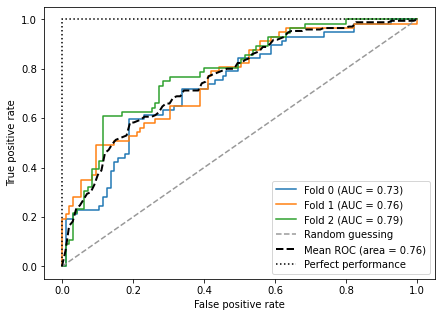

In [33]:
# plot_roc_curve() 함수에 모델과 테스트 데이터를 전달하면 RocCurveDisply 객체를 반환하는데, 이 객체에 fpr과 tpr값이 저장되어 있다.

from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    roc_disp = plot_roc_curve(pipe_lr, 
                              X_train2[test], y_train[test], 
                              name=f'Fold {i}', ax=ax)
    mean_tpr += interp(mean_fpr, roc_disp.fpr, roc_disp.tpr)
    mean_tpr[0] = 0.0

plt.plot([0, 1], [0, 1],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 0, 1], [0, 1, 1],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.show()

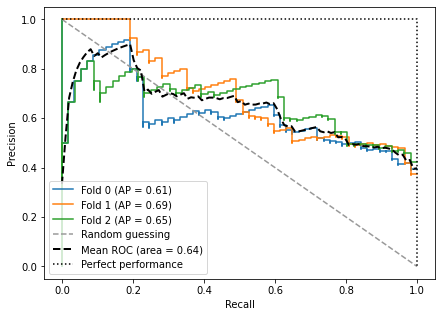

In [34]:
# 정밀도-재현율 커브
from sklearn.metrics import plot_precision_recall_curve

fig, ax = plt.subplots(figsize=(7, 5))

mean_precision = 0.0
mean_recall = np.linspace(0, 1, 100)

for i, (train, test) in enumerate(cv):
    pipe_lr.fit(X_train2[train], y_train[train])
    pr_disp = plot_precision_recall_curve(
        pipe_lr, X_train2[test], y_train[test], 
        name=f'Fold {i}', ax=ax)
    mean_precision += interp(mean_recall, pr_disp.recall[::-1], 
                             pr_disp.precision[::-1])

plt.plot([0, 1], [1, 0],
         linestyle='--', color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_precision /= len(cv)
mean_auc = auc(mean_recall, mean_precision)
plt.plot(mean_recall, mean_precision, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.plot([0, 1, 1], [1, 1, 0],
         linestyle=':', color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")

plt.show()

### 6.5.4 다중 분류의 성능 지표

- 이진 분류가 아니라 다중 분류의 경우.. 'macro'와 'micro' 평균 방식을 쓴다.
- 예를 들어 정밀도의 경우..
    - $PRE_{micro} = \dfrac {TP_1 + \dots + TP_k}{TP_1 + \dots + TP_k + FP_1 + \dots + FP_k}$<br><br>
    
    - $PRE_{macro} = \dfrac {PRE_1 + \dots + PRE_k}{k}$

- 마이크로 평균은 각 샘플이나 예측에 동일한 가중치를 부여하고자 할 때 사용한다.
- 매크로 평균은 모든 클래스에 동일한 가중치를 부여하여 분류기의 전반적인 성능을 평가한다.

In [35]:
pre_scorer = make_scorer(score_func=precision_score,
                        pos_label=1,
                        greater_is_better=True,
                        average='micro')

## 6.6 불균형한 클래스 다루기

In [36]:
# 불균형 데이터셋 만들기 (악성종양 1, 양성종양 0)
X_imb = np.vstack((X[y == 0], X[y == 1][:40]))
y_imb = np.hstack((y[y == 0], y[y == 1][:40]))

np.bincount(y_imb)

array([357,  40])

In [37]:
# y pred를 모두 0, 즉 모두 양성종양이라고 예측해도 정확도는 90% 남짓이다
y_pred = np.zeros(y_imb.shape[0])
np.mean(y_pred == y_imb) * 100

89.92443324937027

- 이럴 때 해결책은 여러 가지가 있다.
    - 먼저, 애플리케이션의 목적에 따라 정밀도, 재현율, ROC 곡선 등을 참고할 수도 있다.
    - 아니면 알고리즘의 훈련 과정에서 '소수 클래스에서 발생한 예측 오류에 큰 벌칙을 부여'할 수도 있다.
        - 분류기의 class_weight 메서드를 class_weight='balanced'로 설정할 수 있다.
    - 또는 언더샘플링, 오버샘플링 등을 통해 인공적으로 샘플을 조정하는 방법이 있다.

In [38]:
from sklearn.utils import resample

print('샘플링하기 전 클래스 1의 샘플 개수:', X_imb[y_imb == 1].shape[0])

X_upsampled, y_upsampled = resample(X_imb[y_imb == 1],
                                   y_imb[y_imb == 1],
                                    replace=True,
                                   n_samples=X_imb[y_imb == 0].shape[0],
                                   random_state=123)

print('샘플링한 후 클래스 1의 샘플 개수', X_upsampled.shape[0])

샘플링하기 전 클래스 1의 샘플 개수: 40
샘플링한 후 클래스 1의 샘플 개수 357


In [39]:
X_bal = np.vstack((X[y == 0], X_upsampled))
y_bal = np.hstack((y[y == 0], y_upsampled))

In [40]:
y_pred = np.zeros(y_bal.shape[0])
np.mean(y_pred == y_bal) * 100

50.0

## 7.1 앙상블 학습

In [41]:
Image(url='https://git.io/Jtskl', width=500) 

- 과반수 투표나 다수결 투표로 레이블 예측하려면, 개별 분류기 $C_j$의 예측 레이블을 모아 가장 많은 표를 받은 레이블 $\hat y$를 선택한다.
    - $\hat y = mode\{C_1(\boldsymbol x),C_2(\boldsymbol x),\dots,C_m(\boldsymbol x)\}$

## 7.2 다수결 투표를 사용한 분류 앙상블

### 7.2.1 간단한 다수결 투표 분류기 구현

- 여기서 구현할 알고리즘은 개별 분류기에 가중치를 적용한 메타 분류기를 구축하는 것이다.
- 가중치가 적용된 다수결 투표의 수학적 표현은 다음과 같다:
$$ \hat y = \underset{i}{\operatorname{argmax}} \; \sum^m_{j=1} w_j \chi_A (C_j(\boldsymbol x) = i) $$<br>
- 여기서 $w_j$는 개별 분류기 $C_j$에 연관된 가중치고, $\hat y$는 앙상블이 예측한 클래스 레이블이다.
- A는 a set of unique class labels
- $\chi$는 특성함수(characteristic function) 또는 지시함수(indicator function)이다.
    - 예를 들어.. j번째 분류기의 예측 클래스가 i 이면 $(C_j(\boldsymbol x) = i)$ 가 1을 반환하게 하는 함수다.

In [42]:
# argmax와 bincount 함수로 가중치가 적용된 다수결 투표를 구현할 수 있음
import numpy as np

np.argmax(np.bincount([0, 0, 1],
                     weights=[0.2, 0.2, 0.6]))

1

- 위의 앙상블 식은 다수결 투표에서 '클래스 레이블'을 사용하는데,
- 사실 가능하다면 레이블이 아니라 '예측 클래스 확률'을 사용하는 게 좋다. -->> predict_proba 메서드!
- 확률을 사용하여 클래스 레이블을 예측하는 다수결 투표의 수학적 표현은 다음과 같다:
$$ \hat y = \underset{i}{\operatorname{argmax}} \; \sum^m_{j=1} w_j p_{ij} $$ <br>

- 여기서 $P_{ij}$는 클래스 레이블 $i$에 대한 $j$번째 분류기의 예측 확률이다.

In [47]:
# average와 argmax 함수로 확률 기반의 가중치 적용된 다수결 투표 구현
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex,
               axis=0,
               weights=[0.2, 0.2, 0.6])

print(p)
    # 3개의 분류기로 이진 클래스 예측을 했을 때,
    # 0번 클래스일 확률은 0.58, 1번 클래스일 확률은 0.42
np.argmax(p)

[0.58 0.42]


0

In [10]:
# 알고리즘 구현
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


    # BaseEstimator와 ClassifierMixin 클래스를 상속하여
    # 기본적인 기능들을 자동으로 갖췄다.
        # 예를 들어, 분류기의 매개변수를 설정하고 반환하는 get_params와 set_params
        # 그리고 예측 정확도를 계산하는 score 메서드 등
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """다수결 투표 앙상블 분류기
    
    매개변수
    ----------
    classifiers : 배열 타입, 크기 = [n_classifiers]
      앙상블에 사용할 분류기
    
    vote : str, {'classlabel', 'probability'}
      기본값: 'classlabel'
      'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 된다.
      'probability'면 확률 합이 가장 큰 인덱스로 클래스 레이블을 예측한다.
      
    weights : 배열 타입, 크기 = [n_classifiers]
      선택 사항, 기본값: None
      'int' 또는 'float' 값의 리스트가 주어지면 분류기에 이 가중치가 적용된다.
      'weights=None'이면 모든 분류기를 동일하게 취급한다
    """
    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in\
                                 _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in {'probability', 'classlbael'}:
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기와 가중치 개수는 같아야 합니다'
                             '; 가중치 %d 개, 분류기 %d 개'
                             % (len(self.weights), len(self.classifiers)))
            
        # self.predict 메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용한다.
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
            # init할 때 받은 classifier를 fit하는 중에
            # 클래스 레이블에 labelencoder까지 해준다.
                # fitted_clf는 self.classifiers_에 담아둔다.
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            # 'classlabel' 투표
            # clf.predict 메서드를 사용해서 결과를 모은다
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_].T)
            
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                                           axis=1,
                                           arr=predictions)
        
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0,
                               weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier,
                         self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.itmes():
                for key, value in step.get_params(deep=True).itmems():
                    out['%s__%s' % (name, key)] = value
                return out

### 7.2.2 다수결 투표 방식을 사용하여 예측 만들기